In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

# Importação dos dados
* Um CSV para cada campus
* data: de 2019-02-18 (segunda semana de aula) até 019-06-28 (penultima semana de aula)
* Granularidade: 1h (potência agregada pela média)
* Dados climáticos obtidos pela plataforma yr
* Colunas
  * potencia ativa da fase A (Kw)
  * Temperatura (ºC)
  * Pressão (hPa)


In [2]:
raw = pd.read_csv ('../../datasets/2019-1 Reitoria.csv', sep=',')

In [3]:
raw.describe()

,pa,temp_celsius,pressao
count,3140.000000,3145.000000,3145.000000
mean,8.444703,22.123370,1015.875167
std,5.948546,3.047656,4.550072
min,2.370725,13.000000,1003.000000
25%,4.980622,20.000000,1013.000000
50%,5.676000,22.000000,1015.700000
75%,9.956032,24.000000,1018.900000
max,35.655490,34.000000,1028.100000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e00f38ba8>,
      dtype=object)

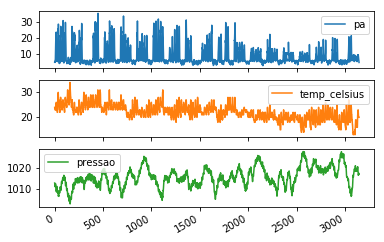

In [4]:
raw.plot(subplots=True)

Text(0.5, 0, 'Potência Ativa (KW)')

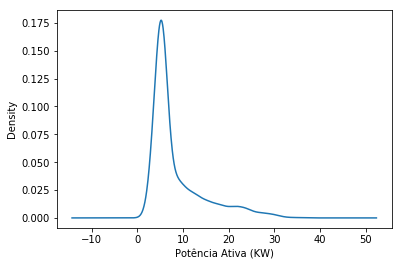

In [5]:
raw['pa'].plot.kde().set_xlabel("Potência Ativa (KW)")

Text(0.5, 0, 'temperatura (ºC)')

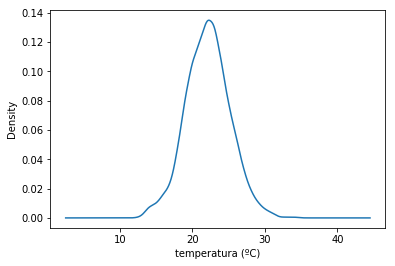

In [6]:
raw['temp_celsius'].plot.kde().set_xlabel("temperatura (ºC)")

Text(0.5, 0, 'Pressão (hPa)')

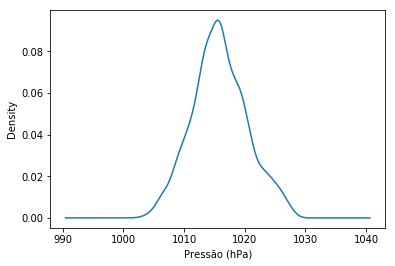

In [7]:
raw['pressao'].plot.kde().set_xlabel("Pressão (hPa)")

# Data cleaning
* Filtra horários de aula
* remover linhas incompletas (sistema fora do ar)
* remover oulier (falhas na coleta de dados).
* remover dias não-letivos
* remover dias com falhas na medição (sistema fora do ar)

In [8]:
processed = raw.dropna()
processed = processed.set_index(pd.to_datetime (processed['momento'])).drop('momento', axis=1)

In [9]:
## Remove fins de semana
# Create an index of just the date portion of your index (this is the slow step)
dfDays = pd.to_datetime(processed.index.date)

# Create a range of business days over that period
dfBdays = pd.bdate_range(start=processed.index[0].date(), end=processed.index[-1].date())

#Filter the series to just those days contained in the business day range.
filtered = processed[dfDays.isin(dfBdays)]

In [10]:
## Removendo dias não-letivos ou com erros
# março
# abril 8, 15, 18,19, 26, 29
# maio 1, 10, 13, 17,
# junho 20, 21
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 8))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 15))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 18))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 19))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 26))]
filtered = filtered[~((filtered.index.month == 4) & (filtered.index.day == 29))]
filtered = filtered[~((filtered.index.month == 5) & (filtered.index.day == 1))]
filtered = filtered[~((filtered.index.month == 5) & (filtered.index.day == 10))]
filtered = filtered[~((filtered.index.month == 5) & (filtered.index.day == 13))]
filtered = filtered[~((filtered.index.month == 5) & (filtered.index.day == 17))]
filtered = filtered[~((filtered.index.month == 6) & (filtered.index.day == 20))]
filtered = filtered[~((filtered.index.month == 6) & (filtered.index.day == 21))]

In [11]:
# Selecionando horários de aula
filtered1 = filtered.between_time('08:00:00', '11:00:00')
filtered2 = filtered.between_time('14:00:00', '17:00:00')
filtered = pd.concat([filtered1, filtered2])

In [12]:
filtered = filtered[~((filtered['pa']<8) & (filtered['temp_celsius']>25))]

Text(0, 0.5, 'Potência ativa (KW)')

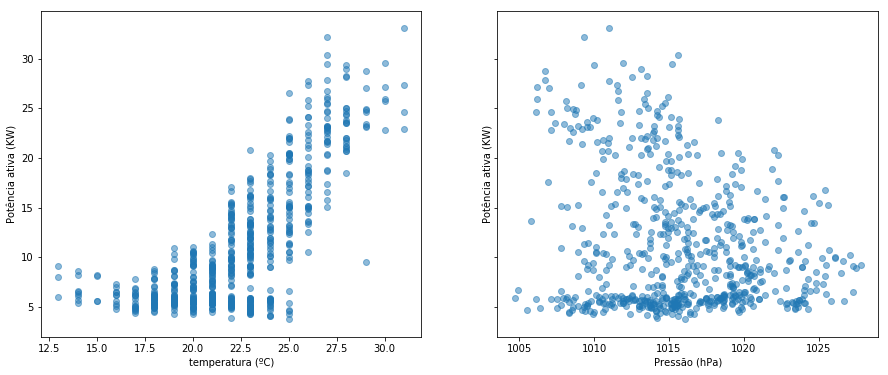

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,6))
ax1.scatter(filtered['temp_celsius'], filtered['pa'], Alpha=0.5)
ax1.set_xlabel("temperatura (ºC)")
ax1.set_ylabel("Potência ativa (KW)")
ax2.scatter(filtered['pressao'], filtered['pa'], Alpha=0.5)
ax2.set_xlabel("Pressão (hPa)")
ax2.set_ylabel("Potência ativa (KW)")

In [14]:
filtered.describe()

,pa,temp_celsius,pressao
count,651.000000,651.000000,651.000000
mean,11.244997,22.307220,1015.765591
std,6.583779,3.326943,4.680297
min,3.793769,13.000000,1004.700000
25%,5.787413,20.000000,1012.600000
50%,9.069988,22.000000,1015.500000
75%,15.057237,24.500000,1019.100000
max,33.037029,31.000000,1027.800000


In [15]:
# Cross validation split
from sklearn.model_selection import train_test_split 
X = filtered.drop('pa', axis=1)
y = filtered ['pa']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30) 

# Linear Regression

In [16]:
model1 = LinearRegression()
model1.fit (X_train, y_train)
pd.DataFrame(model1.coef_,X.columns,columns=['Coefficient'])

,Coefficient
temp_celsius,1.606842
pressao,0.145034


MAE:                 3.3335834643760105
RMSE:                4.229759047784697
Percentual:          29.260977264111173 %


Text(0, 0.5, 'Valores previstos')

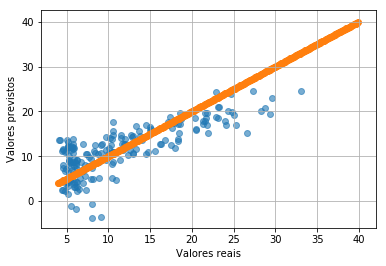

In [17]:
from sklearn import metrics
y_hat1 = model1.predict(X_test)

print ("MAE:                ", metrics.mean_absolute_error(y_test, y_hat1))
print ("RMSE:               ", np.sqrt(metrics.mean_squared_error(y_test, y_hat1)))
print ("Percentual:         ", metrics.mean_absolute_error(y_test,y_hat1)/y_test.mean()*100, "%")

# Previsto vs real
line = np.arange(4, 40, 0.1)

plt.scatter(y_test,y_hat1, Alpha=0.6)
plt.scatter(line,line)
plt.grid(True)
plt.xlabel("Valores reais")
plt.ylabel("Valores previstos")

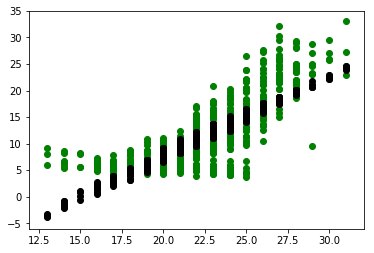

In [18]:
plt.scatter(X['temp_celsius'], y,color='g')
plt.scatter(X['temp_celsius'], model1.predict(X),color='k')

plt.show()

# Random Forest

In [19]:
import sklearn.metrics as metrics
import math
from sklearn.ensemble import RandomForestRegressor

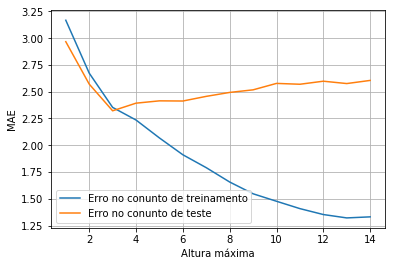

In [20]:
mae1 = {}
mae2 = {}
for k in range(1,15, 1):
    model2 = RandomForestRegressor(max_depth=k, n_estimators=100, criterion='mae').fit(X_train,y_train)
    y_hat = model2.predict(X_train)
    mae1[k] = metrics.mean_absolute_error(y_train,y_hat)
    y_hat = model2.predict(X_test)
    mae2[k] = metrics.mean_absolute_error(y_test,y_hat)

plt.figure()
plt.plot(list(mae1.keys()), list(mae1.values()), label='Erro no conunto de treinamento')
plt.plot(list(mae2.keys()), list(mae2.values()), label='Erro no conunto de teste')
plt.legend(loc='lower left')
plt.xlabel("Altura máxima")
plt.ylabel("MAE")
plt.grid(True)

In [24]:
# Random Forest
model2 = RandomForestRegressor(max_depth=3, n_estimators=100)
model2.fit(X_train,y_train)

# Model Evaluation
y_hat2 = model2.predict(X_test)

print ("MAE:                ", metrics.mean_absolute_error(y_test,y_hat2))
print ("RMSE:               ", math.sqrt(metrics.mean_squared_error(y_test,y_hat2)))
print ("Percentual:         ", metrics.mean_absolute_error(y_test,y_hat2)/y_test.mean()*100, "%")

# Feature analysis
print ("=====================================")
print ("FEATURE IMPORTANCE:")
for i in range(model2.feature_importances_.size):
    print (X_train.columns[i], "=", model2.feature_importances_[i])

MAE:                 2.5191949429988294
RMSE:                3.357453560013624
Percentual:          22.11257247304309 %
FEATURE IMPORTANCE:
temp_celsius = 0.9260704157703402
pressao = 0.0739295842296594


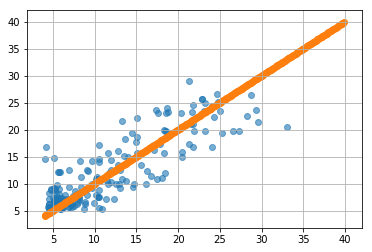

In [25]:
# Previsto vs real
line = np.arange(4, 40, 0.1)

plt.scatter(y_test,y_hat, Alpha=0.6)
plt.scatter(line,line)
plt.grid(True)

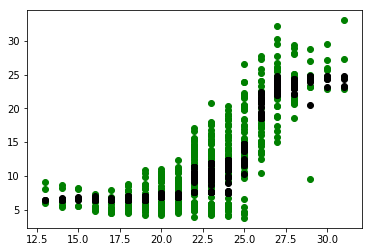

In [26]:
plt.scatter(X['temp_celsius'], y,color='g')
plt.scatter(X['temp_celsius'], model2.predict(X),color='k')

plt.show()